In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
import sys
sys.path.append('../../transformers/src')

import math
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from transformers import AdamW, pipeline, PegasusForConditionalGeneration, PegasusTokenizer
from transformers import BartConfig
from transformers import AutoConfig
from transformers.models.bart.modeling_bart import EncoderLayer, SinusoidalPositionalEmbedding, LayerNorm

In [2]:
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("torch_device:",torch_device)

torch_device: cuda


In [10]:
# model_name = 'google/pegasus-xsum'
model_name = 'google/pegasus-cnn_dailymail'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
tokenizer.model_max_length

1024

In [11]:
sample_text = [
    "Yuji Naraki [SAYS] Hi, John! [EOU] How are you? [EOU] [EOT] John [SAYS] I'm good. Thanks. [EOU] [EOT] Yuji Naraki [SAYS] Hi, John! [EOU] How are you? [EOU] [EOT]",
    "Naraki [SAYS] Good evening, Mr.Kim. [EOU] How was your today? [EOU] [EOT] Kim [SAYS] It is a pleasant day. [EOU] [EOT] Daive [SAYS] It is a pleasant day. [EOU] [EOT]"
]
special_tokens_dict = {'additional_special_tokens': ['[SAYS]','[EOU]','[EOT]']}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)

batch = tokenizer.prepare_seq2seq_batch(sample_text, truncation=True, padding='longest')
print('  '.join([tokenizer.convert_ids_to_tokens(i) for i in batch['input_ids'][0]]))

▁Yu  ji  ▁Nar  aki  [SAYS]  ▁Hi  ,  ▁John  !  [EOU]  ▁How  ▁are  ▁you  ?  [EOU]  [EOT]  ▁John  [SAYS]  ▁I  '  m  ▁good  .  ▁Thanks  .  [EOU]  [EOT]  ▁Yu  ji  ▁Nar  aki  [SAYS]  ▁Hi  ,  ▁John  !  [EOU]  ▁How  ▁are  ▁you  ?  [EOU]  [EOT]  </s>


In [12]:
# see min_length, value of attention_mask
mode = 'train'
source_list = []
with open("/home/naraki/dialogsum/samsum_dataset2/{}.source".format(mode), "r") as f:
    source_list = f.read().split('\n')
target_list = []
with open("/home/naraki/dialogsum/samsum_dataset2/{}.target".format(mode), "r") as f:
    target_list = f.read().split('\n')

assert len(source_list)==len(target_list)
    
min_len = 1000
max_len = 0
count = 0
source_len_list = []
target_len_list = []
for i, (source, target) in enumerate(zip(source_list, target_list)):
    batch = tokenizer.prepare_seq2seq_batch([source], truncation=True, padding='longest')
    text_len = len(batch.input_ids[0])
    source_len_list.append(text_len)
    batch = tokenizer.prepare_seq2seq_batch([target], truncation=True, padding='longest')
    text_len = len(batch.input_ids[0])
    target_len_list.append(text_len)
    if target != 'yyy' and target != 'test':
        if text_len < min_len:
            min_len = text_len
    if text_len > 64:
        count+=1
#         print("Source",i, ": ", source)
#         print("Target",i, ": ", target)
    if text_len > max_len:
        max_len = text_len
    if 0 in batch.attention_mask[0]:
        # 呼ばれたらあかん
        print(batch)
print("min_len", min_len)
print("max_len", max_len)
count/len(source_list)

min_len 4
max_len 80


0.011676057294141605

In [13]:
tokenizer.model_max_length

1024

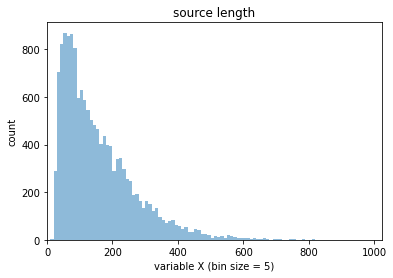

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

bins = np.arange(0, 1024, 10) # fixed bin size

plt.xlim([0, 1024])

plt.hist(source_len_list, bins=bins, alpha=0.5)
plt.title('source length')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')

plt.show()

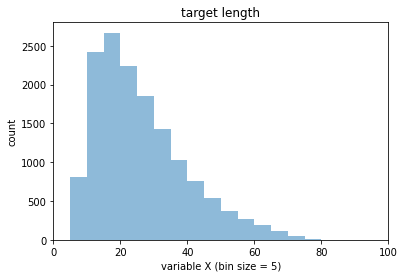

In [15]:
bins = np.arange(0, 100, 5) # fixed bin size

plt.xlim([0, 100])

plt.hist(target_len_list, bins=bins, alpha=0.5)
plt.title('target length')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')

plt.show()